# Generative Adversarial Network

## Ressources
* [paper](https://arxiv.org/abs/1406.2661)

In [1]:
%matplotlib inline
import importlib
import utils; importlib.reload(utils)
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils import limit_mem

Using TensorFlow backend.


In [2]:
limit_mem()

## Data

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [4]:
n_train = len(X_train)
n_test = len(X_test)

Transform into 2-dimensional

In [5]:
X_train = X_train.reshape(n_train, -1).astype(np.float32)
X_test = X_test.reshape(n_test, -1).astype(np.float32)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


Make value between 0-1 (RGB=255)

In [6]:
X_train /= 255.
X_test /= 255.

In [7]:
x_shape = X_train.shape[1];x_shape

784

## Train

### Generator (G)

#### Helper functions

In [8]:
from utils import plot_multi

Noise

In [9]:
x_len = 100

In [10]:
def noise(bs): return np.random.rand(bs, x_len)

Plot a bunch of generated images

In [11]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28, 28), cmap='gray')

#### Model

In [12]:
MLP_G = Sequential([
    Dense(200, input_shape=(x_len,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(x_shape, activation='sigmoid')
])

### Discriminator (D)

#### Helper functions

Create a batch of 50% real and 50% fake/ generated data with appropriate labels(0=real/1=fake)

In [13]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0, n_train, size=sz)]
    fake_img = G.predict(noise(sz))
    
    X = np.concatenate((real_img, fake_img))
    labels = [0]*sz + [1]*sz
    return X, labels

#### Model

In [14]:
MLP_D = Sequential([
    Dense(300, input_shape=(x_shape,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid')
])
MLP_D.compile(Adam(1e-4), 'binary_crossentropy')

### Model

We want to alternate between training the generator(G) for a while and then switch on the discriminator(D), once the generated results are reasonable, ...

In [15]:
def make_trainable(net, val):
    net.trainable = val
    for layer in net.layers:
        layer.trainable = val

In [16]:
def train(D, G, m, epochs=5000, bs=128):
    dl = []
    gl = []
    for epoch in tqdm(range(epochs)):
        X, y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X, y))
        make_trainable(D, False)
        
        preds = m.train_on_batch(noise(bs), np.zeros([bs]))
        gl.append(preds)
        make_trainable(D, True)
    return dl, gl

In [17]:
MLP_m = Sequential([MLP_G, MLP_D])
MLP_m.compile(Adam(1e-4), 'binary_crossentropy')

In [18]:
dl, gl = train(MLP_D, MLP_G, MLP_m, 8000)

100%|██████████| 8000/8000 [00:41<00:00, 190.97it/s]


The loss plots for normal GANs are nearly impossible to interpret

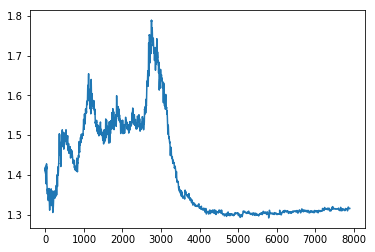

In [19]:
plt.plot(dl[100:])

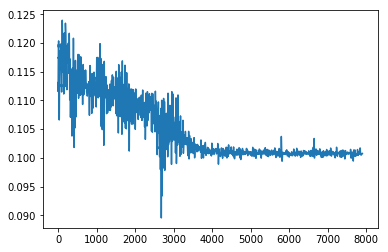

In [20]:
plt.plot(gl[100:])

Mode collapse:

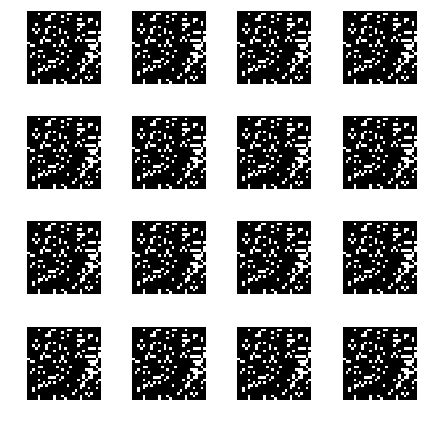

In [21]:
plot_gen(MLP_G)

Let's instead try DCGANs